<a href="https://www.kaggle.com/code/nguyenlamvydat/ai-senseg?scriptVersionId=238730681" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassAccuracy
import copy
from torchsummary import summary

In [2]:
class SemanticSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir)])
        self.label_paths = sorted([os.path.join(label_dir, lbl) for lbl in os.listdir(label_dir)])
        self.class_colors = {
            (2, 0, 0): 0,       
            (127, 0, 0): 1,     
            (248, 163, 191): 2  
        }
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = cv2.imread(self.label_paths[idx])
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

        label_mask = np.zeros(label.shape[:2], dtype=np.uint8)
        for rgb, idx in self.class_colors.items():
            label_mask[np.all(label == rgb, axis=-1)] = idx

        if self.transform:
            image = self.transform(image)
            label_mask = torch.from_numpy(label_mask).long()

        return image, label_mask

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

dataset = SemanticSegmentationDataset(
    image_dir='/kaggle/input/spectro/input',
    label_dir='/kaggle/input/spectro/label',
    transform=train_transform)

total_size = len(dataset)
train_size = int(0.8 * total_size)  
val_size = total_size - train_size  
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Train size: 4800, Validation size: 1200


In [3]:
# Channel Attention
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        intermediate_channels = max(1, in_channels // reduction)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, intermediate_channels, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(intermediate_channels, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out) * x

# Spatial Attention
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return self.sigmoid(out) * x

# CBAM Module
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

# Depthwise Separable Convolution
class DWConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DWConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride,
                                   padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1,
                                   padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Multi-scale Feature Extraction
class MultiScaleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiScaleBlock, self).__init__()
        branch_channels = out_channels // 3

        self.branch1 = DWConv(in_channels, branch_channels)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(branch_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(branch_channels, branch_channels, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(branch_channels),
            nn.ReLU(inplace=True)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(branch_channels),
            nn.ReLU(inplace=True)
        )

        concat_channels = branch_channels * 3
        self.cbam = CBAM(concat_channels, reduction=16)
        self.adjust_channels = nn.Conv2d(concat_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        out = torch.cat([b1, b2, b3], dim=1)
        out = self.cbam(out)
        out = self.adjust_channels(out)
        return out

# SSNet
class SSNet(nn.Module):
    def __init__(self, num_classes=3):
        super(SSNet, self).__init__()

        # Encoder
        self.enc1 = MultiScaleBlock(3, 16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = MultiScaleBlock(16, 32)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc3 = MultiScaleBlock(32, 64)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.enc4 = DWConv(64, 128)

        # Decoder
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.dec1 = MultiScaleBlock(128, 64)

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 32, kernel_size=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.dec2 = MultiScaleBlock(64, 32)

        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(32, 16, kernel_size=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.dec3 = MultiScaleBlock(32, 16)

        self.final = nn.Conv2d(16, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        e4 = self.enc4(p3)

        d1 = self.up1(e4)
        d1 = torch.cat([d1, e3], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat([d3, e1], dim=1)
        d3 = self.dec3(d3)

        out = self.final(d3)
        return out


In [4]:
def train_epoch(model, dataloader, criterion, optimizer, device, num_classes):
    model.train()
    running_loss = 0.0  
    accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
    iou_metric = MulticlassJaccardIndex(num_classes=num_classes).to(device)
    pbar = tqdm(dataloader, desc='Training', unit='batch')
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)       
        optimizer.zero_grad()
        outputs = model(images)    
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()   
        running_loss += loss.item() * images.size(0)      
        preds = torch.argmax(outputs, dim=1)     
        accuracy_metric(preds, labels)
        iou_metric(preds, labels)
        pbar.set_postfix({
            'Batch Loss': f'{loss.item():.4f}',
            'Mean Accuracy': f'{accuracy_metric.compute():.4f}',
            'Mean IoU': f'{iou_metric.compute():.4f}',
        }) 
    epoch_loss = running_loss / len(dataloader.dataset)  
    mean_accuracy = accuracy_metric.compute().cpu().numpy()
    mean_iou = iou_metric.compute().cpu().numpy()
   
    return epoch_loss, mean_accuracy, mean_iou

In [5]:
def evaluate(model, dataloader, criterion, device, num_classes):
    model.eval()
    running_loss = 0.0    
    accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
    iou_metric = MulticlassJaccardIndex(num_classes=num_classes).to(device)
    pbar = tqdm(dataloader, desc='Evaluating', unit='batch')
    with torch.no_grad():
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            # Update metrics
            accuracy_metric(preds, labels)
            iou_metric(preds, labels)
            # Update tqdm description with metrics
            pbar.set_postfix({
                'Batch Loss': f'{loss.item():.4f}',
                'Mean Accuracy': f'{accuracy_metric.compute():.4f}',
                'Mean IoU': f'{iou_metric.compute():.4f}',
            })
    
    epoch_loss = running_loss / len(dataloader.dataset)
    mean_accuracy = accuracy_metric.compute().cpu().numpy()
    mean_iou = iou_metric.compute().cpu().numpy()
    
    return epoch_loss, mean_accuracy, mean_iou

In [6]:
# Đảm bảo bạn có ít nhất 2 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() < 2:
    print("1 GPU")
else:
    print(f"{torch.cuda.device_count()} GPUs.")

classes = 3  
model = SSNet(classes).to(device)

def count_parameters(model):  
    return sum(p.numel() for p in model.parameters())

total_params = count_parameters(model)
print(f"Total parameters: {total_params}")

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model) 

# Kiểm tra mô hình
summary(model, (3, 256, 256))

criterion = nn.CrossEntropyLoss()  
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Khởi tạo các list để lưu giá trị
train_losses = []
train_accuracies = []
train_ious = []
val_losses = []
val_accuracies = []
val_ious = []

epoch_saved = 0
best_val_mAcc = 0.0  
best_model_state = None

for epoch in range(num_epochs):
    epoch_loss_train, mAcc_train, mIoU_train = train_epoch(model, train_dataloader, criterion, optimizer, device, classes)
    epoch_loss_val, mAcc_val, mIoU_val = evaluate(model, val_dataloader, criterion, device, classes)
    
    # Lưu giá trị vào các list
    train_losses.append(epoch_loss_train)
    train_accuracies.append(mAcc_train)
    train_ious.append(mIoU_train)
    val_losses.append(epoch_loss_val)
    val_accuracies.append(mAcc_val)
    val_ious.append(mIoU_val)
    
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {epoch_loss_train:.4f}, Mean Accuracy: {mAcc_train:.4f}, Mean IoU: {mIoU_train:.4f}")
    print(f"Validation Loss: {epoch_loss_val:.4f}, Mean Accuracy: {mAcc_val:.4f}, Mean IoU: {mIoU_val:.4f}")

    if mAcc_val >= best_val_mAcc:
        epoch_saved = epoch + 1 
        best_val_mAcc = mAcc_val
        best_model_state = copy.deepcopy(model.state_dict())
    
print("===================")
print(f"Best Model at epoch : {epoch_saved}")
model.load_state_dict(best_model_state)
if isinstance(model, torch.nn.DataParallel):
    model = model.module
model_save = torch.jit.script(model)
model_save.save("Nhom7.pt")
# Check again
model = torch.jit.load("Nhom7.pt")
epoch_loss_val, mAcc_val, mIoU_val = evaluate(model, val_dataloader, criterion, device, classes)
print(f"Validation Loss: {epoch_loss_val:.4f}, Mean Accuracy: {mAcc_val:.4f}, Mean IoU: {mIoU_val:.4f}")

1 GPU
Total parameters: 145755
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 256, 256]              27
            Conv2d-2          [-1, 5, 256, 256]              15
       BatchNorm2d-3          [-1, 5, 256, 256]              10
              ReLU-4          [-1, 5, 256, 256]               0
            DWConv-5          [-1, 5, 256, 256]               0
            Conv2d-6          [-1, 5, 256, 256]             135
       BatchNorm2d-7          [-1, 5, 256, 256]              10
              ReLU-8          [-1, 5, 256, 256]               0
            Conv2d-9          [-1, 5, 256, 256]             625
      BatchNorm2d-10          [-1, 5, 256, 256]              10
             ReLU-11          [-1, 5, 256, 256]               0
           Conv2d-12          [-1, 5, 256, 256]             135
      BatchNorm2d-13          [-1, 5, 256, 256]              10
        

Evaluating: 100%|██████████| 38/38 [00:36<00:00,  1.04batch/s, Batch Loss=0.2585, Mean Accuracy=0.8575, Mean IoU=0.8003]


Epoch 1/10
Train Loss: 0.5482, Mean Accuracy: 0.6981, Mean IoU: 0.5174
Validation Loss: 0.2770, Mean Accuracy: 0.8575, Mean IoU: 0.8003


Evaluating: 100%|██████████| 38/38 [00:19<00:00,  1.98batch/s, Batch Loss=0.1805, Mean Accuracy=0.9691, Mean IoU=0.9428]


Epoch 2/10
Train Loss: 0.2180, Mean Accuracy: 0.7945, Mean IoU: 0.7198
Validation Loss: 0.1870, Mean Accuracy: 0.9691, Mean IoU: 0.9428


Evaluating: 100%|██████████| 38/38 [00:18<00:00,  2.01batch/s, Batch Loss=0.1191, Mean Accuracy=0.9800, Mean IoU=0.9670]


Epoch 3/10
Train Loss: 0.1565, Mean Accuracy: 0.9646, Mean IoU: 0.9456
Validation Loss: 0.1354, Mean Accuracy: 0.9800, Mean IoU: 0.9670


Evaluating: 100%|██████████| 38/38 [00:18<00:00,  2.03batch/s, Batch Loss=0.1096, Mean Accuracy=0.9754, Mean IoU=0.9614]


Epoch 4/10
Train Loss: 0.1345, Mean Accuracy: 0.9690, Mean IoU: 0.9511
Validation Loss: 0.1284, Mean Accuracy: 0.9754, Mean IoU: 0.9614


Evaluating: 100%|██████████| 38/38 [00:18<00:00,  2.00batch/s, Batch Loss=0.0942, Mean Accuracy=0.9698, Mean IoU=0.9575]


Epoch 5/10
Train Loss: 0.1159, Mean Accuracy: 0.9746, Mean IoU: 0.9606
Validation Loss: 0.1093, Mean Accuracy: 0.9698, Mean IoU: 0.9575


Evaluating: 100%|██████████| 38/38 [00:19<00:00,  1.97batch/s, Batch Loss=0.0262, Mean Accuracy=0.9832, Mean IoU=0.9733]


Epoch 6/10
Train Loss: 0.0573, Mean Accuracy: 0.9837, Mean IoU: 0.9711
Validation Loss: 0.0333, Mean Accuracy: 0.9832, Mean IoU: 0.9733


Evaluating: 100%|██████████| 38/38 [00:18<00:00,  2.03batch/s, Batch Loss=0.0373, Mean Accuracy=0.9788, Mean IoU=0.9659]


Epoch 7/10
Train Loss: 0.0339, Mean Accuracy: 0.9838, Mean IoU: 0.9702
Validation Loss: 0.0413, Mean Accuracy: 0.9788, Mean IoU: 0.9659


Evaluating: 100%|██████████| 38/38 [00:18<00:00,  2.02batch/s, Batch Loss=0.0879, Mean Accuracy=0.9806, Mean IoU=0.9553]


Epoch 8/10
Train Loss: 0.0311, Mean Accuracy: 0.9850, Mean IoU: 0.9722
Validation Loss: 0.0552, Mean Accuracy: 0.9806, Mean IoU: 0.9553


Evaluating: 100%|██████████| 38/38 [00:19<00:00,  1.99batch/s, Batch Loss=0.0243, Mean Accuracy=0.9846, Mean IoU=0.9750]


Epoch 9/10
Train Loss: 0.0304, Mean Accuracy: 0.9851, Mean IoU: 0.9724
Validation Loss: 0.0283, Mean Accuracy: 0.9846, Mean IoU: 0.9750


Evaluating: 100%|██████████| 38/38 [00:19<00:00,  1.97batch/s, Batch Loss=0.0227, Mean Accuracy=0.9887, Mean IoU=0.9764]


Epoch 10/10
Train Loss: 0.0247, Mean Accuracy: 0.9880, Mean IoU: 0.9782
Validation Loss: 0.0262, Mean Accuracy: 0.9887, Mean IoU: 0.9764
Best Model at epoch : 10


Evaluating: 100%|██████████| 38/38 [00:20<00:00,  1.89batch/s, Batch Loss=0.0227, Mean Accuracy=0.9887, Mean IoU=0.9764]

Validation Loss: 0.0262, Mean Accuracy: 0.9887, Mean IoU: 0.9764


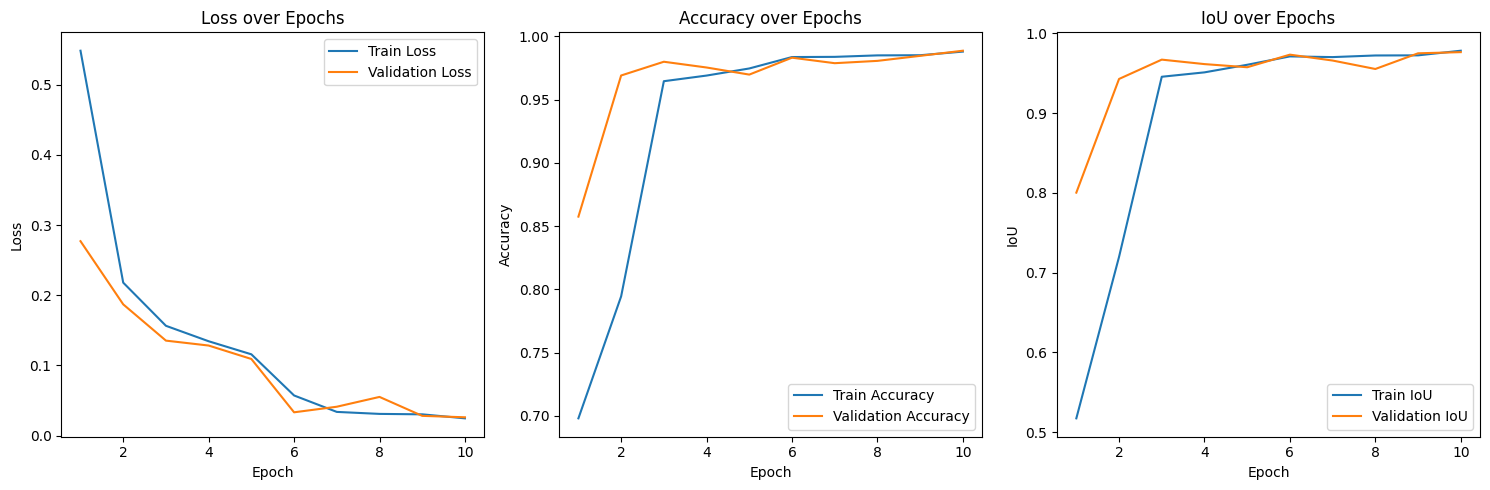

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# Biểu đồ Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Biểu đồ Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Biểu đồ IoU
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), train_ious, label='Train IoU')
plt.plot(range(1, num_epochs + 1), val_ious, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('IoU over Epochs')
plt.legend()

plt.tight_layout()
plt.show()